In [848]:
# Importing neccessary modules
import cv2
import matplotlib.pyplot as plt
import os
import pytesseract
import re
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [849]:
# Define the paths to the image and template
image_path = './resources/slika5.jpg'
template_path = './templates/ZG-template.jpg'

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Image file not found at {image_path}")
else:
    print(f"Image file found at {image_path}")

# Check if the template file exists
if not os.path.exists(template_path):
    print(f"Template file not found at {template_path}")
else:
    print(f"Template file found at {template_path}")

Image file found at ./resources/slika5.jpg
Template file found at ./templates/ZG-template.jpg


Image loaded successfully.
Template loaded successfully.


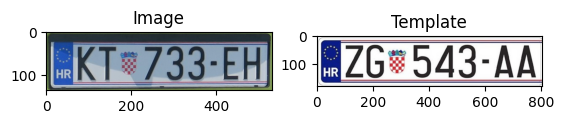

In [850]:
# Load the image and template
image = cv2.imread(image_path)
template = cv2.imread(template_path)

# Create figure
fig = plt.figure()

# Setting values to rows and column variables
rows = 1
columns = 2

if image is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully.")
    fig.add_subplot(rows, columns, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
    plt.title("Image")

if template is None:
    print("Failed to load template.")
else:
    print("Template loaded successfully.")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))  # Display grayscale image
    plt.title("Template")

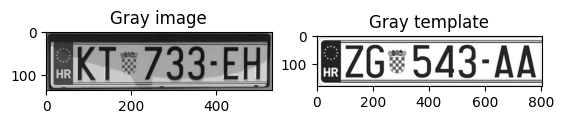

In [851]:
# Proceed only if both image and template are loaded successfully
if image is not None and template is not None:
    # Create figure
    fig2 = plt.figure()
    # Setting values to rows and column variables
    rows = 1
    columns = 2
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    fig2.add_subplot(rows, columns, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Gray image")
    fig2.add_subplot(rows, columns, 2)
    plt.imshow(gray_template, cmap='gray')
    plt.title("Gray template")


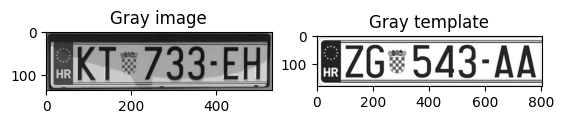

In [852]:
# Check if the conversion was successful
if gray_image is None:
    print("Error converting image to grayscale")
else:
    # Preprocess the image and template
    gray_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    gray_template = cv2.GaussianBlur(gray_template, (5, 5), 0)
    # Create figure
    fig3 = plt.figure()
    # Setting values to rows and column variables
    rows = 1
    columns = 2
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    fig3.add_subplot(rows, columns, 1)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Gray image")
    fig3.add_subplot(rows, columns, 2)
    plt.imshow(gray_template, cmap='gray')
    plt.title("Gray template")

Image dimensions: 531x137
Template dimensions: 805x178
Resized template dimensions: 531x117
Method: 2, max_val = 0.5962656736373901
Raw detected plate text: | KT 733 EH
Formatted plate text:  KT 733 EH



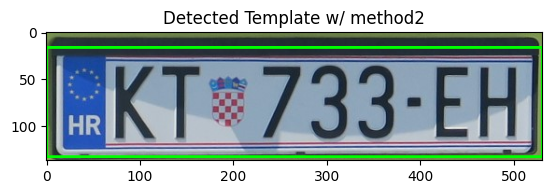

Method: 3, max_val = 1456894080.0


In [853]:
# Check the dimensions of the images
img_height, img_width = gray_image.shape
tmpl_height, tmpl_width = gray_template.shape

print(f"Image dimensions: {img_width}x{img_height}")
print(f"Template dimensions: {tmpl_width}x{tmpl_height}")

# Resize the template if it is larger than the image
if tmpl_height > img_height or tmpl_width > img_width:
    scale_factor = min(img_height / tmpl_height, img_width / tmpl_width)
    new_tmpl_height = int(tmpl_height * scale_factor)
    new_tmpl_width = int(tmpl_width * scale_factor)
    gray_template = cv2.resize(gray_template, (new_tmpl_width, new_tmpl_height))
    print(f"Resized template dimensions: {new_tmpl_width}x{new_tmpl_height}")

# List of template matching methods to try
methods = [
    cv2.TM_SQDIFF_NORMED,
    cv2.TM_CCORR,
    cv2.TM_CCORR_NORMED,
    cv2.TM_CCOEFF,
    cv2.TM_CCOEFF_NORMED
]

# Set a lower threshold for detection
threshold = 0.7

for method in methods:
    # Perform template matching using grayscale images
    result = cv2.matchTemplate(gray_image, gray_template, method)

    # Find the minimum and maximum correlation scores and their locations
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(f"Method: {method + 1}, max_val = {max_val}")

    # Determine the best match location based on the method
    if method is cv2.TM_SQDIFF_NORMED:
        best_match_loc = min_loc
        best_match_val = min_val
        match_condition = best_match_val <= threshold  # For SQDIFF methods, lower is better
    else:
        best_match_loc = max_loc
        best_match_val = max_val
        match_condition = best_match_val >= threshold  # For other methods, higher is better

    # Draw a rectangle around the matched region if the match is above the threshold
    if match_condition:
        top_left = best_match_loc
        h, w = gray_template.shape
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

        # Extract the detected plate region
        detected_plate = gray_image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

        # Apply edge detection
        edges = cv2.Canny(detected_plate, 250, 506, L2gradient = True)
        #plt.imshow(edges)
        # Use pytesseract to extract text from the detected plate region
        plate_text = pytesseract.image_to_string(edges, config='--psm 8')  # PSM 8 is for single word/line
        print(f"Raw detected plate text: {plate_text.strip()}")

        # Post-process the OCR result to match the expected format
        formatted_plate_text = re.sub(r'[^A-Z0-9\s\-.]', '', plate_text)

        print(f"Formatted plate text: {formatted_plate_text}")
        # Display the result using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Detected Template w/ method{method + 1}')
        #plt.axis('off')  # Hide axes
        plt.show()

    else:
        print("No match found above the threshold.")